In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares

from FitAPI import Model, Fitter, ResonancePeakSearcher
import models as md

In [2]:
data_dict = {}       # stores the dataset values as NumPy arrays
metadata_dict = {}   # stores the metadata (attributes) for each dataset

def process_dataset(name, obj):
    if isinstance(obj, h5py.Dataset):
        bias_key = float(obj.attrs.get("bias_current (uA)"))
        if bias_key is not None:
            data_dict[bias_key] = obj[()]
            metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
        else:
            print(f"Warning: Dataset '{name}' missing 'bias_current (uA)' attribute.")

with h5py.File('../Experiments/TRswipe/run-6/data/peaks_data.h5', 'r') as f:
    f.visititems(process_dataset)

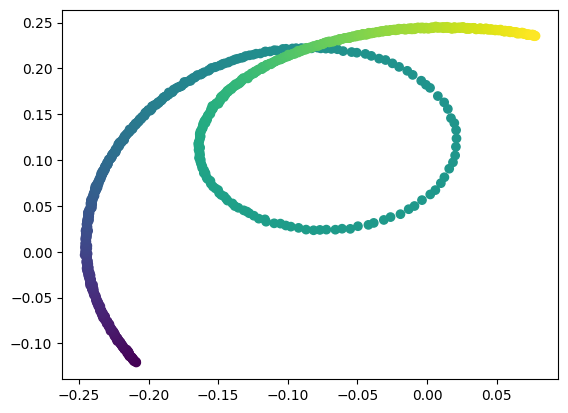

In [3]:
# Example plot of one peak
bias_current = 0.5
peak_data = data_dict[bias_current]
# transpose the data to match the expected shape (rows, columns)
# peak_data = peak_data.T
f = peak_data[0]
I = peak_data[1]
Q = peak_data[2]

plt.scatter(I, Q, c=f, cmap='viridis')

In [23]:
amp = np.sqrt(I**2 + Q**2)
amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
data_test = np.array([f, amp_dBm]).T
data_test

array([[6.22400000e+09, 4.76472511e+01],
       [6.22401001e+09, 4.76404521e+01],
       [6.22402002e+09, 4.76752595e+01],
       ...,
       [6.23397998e+09, 4.78968285e+01],
       [6.23398999e+09, 4.78926573e+01],
       [6.23400000e+09, 4.78729703e+01]], shape=(1000, 2))

In [25]:
# try to fit
model = md.resonance_model
fitter = Fitter(model_function=md.resonance_model, 
                    param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                    data=data_test, 
                    loss_function=LeastSquares
                )

searcher = ResonancePeakSearcher()
result = fitter.fit_magicus(searcher=searcher)

In [17]:
fav_guess = {
    "fmin": 6229355355,
    "f0": 6229355355, #0.1,
    "phi": -0.2369, # 2.1,
    "Qc": 29208,
    "A": 0.0, #1.0,
    "B": 2.8643e-8 ,#1e-9,
    "C": 8.0398e-15,#1e-18,
    "D": -3.5988e-20, # 1e-27
    "K": 0.0, #1e-3,
    "Qt": 29208
    }

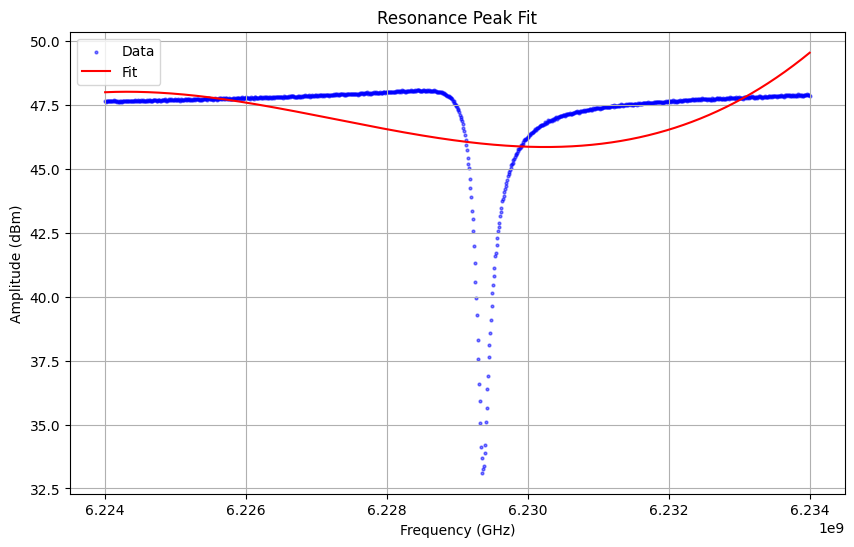

In [26]:
fitted_params = result.values.to_dict()
# Add fmin to the fitted parameters
fitted_params['fmin'] = searcher.params['fmin']
# Plot the fit result
plt.figure(figsize=(10, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], label='Data', color='blue', alpha=0.5, s=4)
plt.plot(data_test[:, 0], model(data_test[:, 0], *fitted_params.values()), label='Fit', color='red')
#plot also the curve with the initial guess
# plt.plot(data_test[:, 0], model(data_test[:, 0], *searcher.params.values()), label='Initial Guess', color='green', linestyle='--')
# plto the curve with fav_guess
# plt.plot(data_test[:, 0], model(data_test[:, 0], *fav_guess.values()), label='Fav Guess', color='orange', linestyle='--')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude (dBm)')
plt.title('Resonance Peak Fit')
plt.legend()
plt.grid()
plt.show()

In [8]:
searcher.params

{'f0': np.float64(6229355355.0),
 'phi': -0.2369,
 'Qt': np.float64(24892.429420861456),
 'Qc': np.float64(37338.64413129218),
 'A': np.float64(47.75960727915124),
 'B': 0.0,
 'C': 0.0,
 'D': 0.0,
 'K': np.float64(-43.93727404598767),
 'fmin': np.float64(6229355355.0)}